# Transfer Learning with PyTorch using Azure Machine Learning

In [158]:
import os
import azureml
import shutil

from azureml.core.model import Model, InferenceConfig
from azureml.core import Workspace, Datastore, Experiment, Run
from azureml.core.compute import ComputeTarget, AmlCompute, AksCompute, ComputeTarget
from azureml.train.dnn import PyTorch
from azureml.widgets import RunDetails

from azureml.core.webservice import Webservice, AksWebservice
from azureml.core.environment import Environment

from azureml.core.dataset import Dataset
from azureml.core.resource_configuration import ResourceConfiguration
from azureml.core.conda_dependencies import CondaDependencies 

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.83


## 1 - Connect to the AML Workspace Environment

In [159]:
azure_ml_workspace_name              = "<INSERT WORKSPACE NAME>"
azure_ml_workspace_resource_group    = "<INSERT RECOURSE GROUP>"
azure_ml_workspace_subscription_id   = "<INSER SUBSCRIPTION ID>"

azure_ml_compute_target_name         = "NV6AICluster"

ExperimentName                       = 'Simpsons-TF-PyTorch-AzureLowlands'

In [160]:
# Connect to workspace
#ws = Workspace.get(name=azure_ml_workspace_name, subscription_id=azure_ml_workspace_subscription_id, resource_group=azure_ml_workspace_resource_group)
#ws.write_config()
ws = Workspace.from_config()

# Connect to compute for training
compute_target = ComputeTarget(workspace=ws, name=azure_ml_compute_target_name)

# Connect to the datastore for the training images
ds = Datastore.get_default(ws)

# Connect to the experiment
exp = Experiment(workspace=ws, name=ExperimentName)

## 2 - Data

### 2.1 Download and extract the data

In [113]:
data_url = "https://github.com/hnky/dataset-lego-figures/raw/master/_download/train-and-validate.zip"
data_path = "./data"
download_path = os.path.join(data_path,"train-and-validate.zip")

In [ ]:
import urllib3 
if not os.path.exists(data_path):
    os.mkdir(data_path,);
urllib.request.urlretrieve(data_url, filename=download_path)

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile(download_path, 'r')
zip_ref.extractall(data_path)
zip_ref.close()
print("Data extracted in: {}".format(data_path))

os.remove(download_path)
print("Downloaded file removed: {}".format(download_path))

### 2.2 Upload the data to AML datastore

In [114]:
# Upload all the data to the datastore
ds.upload(src_dir=data_path, target_path='simpsonslego-v2', overwrite=True, show_progress=True)

Uploading an estimated of 535 files
Uploading ./data\train\Bart-Simpson\IMG_1652.JPG
Uploading ./data\train\Bart-Simpson\IMG_1653.JPG
Uploading ./data\train\Bart-Simpson\IMG_1654.JPG
Uploading ./data\train\Bart-Simpson\IMG_1656.JPG
Uploading ./data\train\Bart-Simpson\IMG_1657.JPG
Uploading ./data\train\Bart-Simpson\IMG_1658.JPG
Uploading ./data\train\Bart-Simpson\IMG_1659.JPG
Uploading ./data\train\Bart-Simpson\IMG_1660.JPG
Uploading ./data\train\Bart-Simpson\IMG_1661.JPG
Uploading ./data\train\Bart-Simpson\IMG_1662.JPG
Uploading ./data\train\Bart-Simpson\IMG_1663.JPG
Uploading ./data\train\Bart-Simpson\IMG_1664.JPG
Uploading ./data\train\Bart-Simpson\IMG_1666.JPG
Uploading ./data\train\Bart-Simpson\IMG_1667.JPG
Uploading ./data\train\Bart-Simpson\IMG_1668.JPG
Uploading ./data\train\Bart-Simpson\IMG_1670.JPG
Uploading ./data\train\Bart-Simpson\IMG_1672.JPG
Uploading ./data\train\Bart-Simpson\IMG_1673.JPG
Uploading ./data\train\Bart-Simpson\IMG_1674.JPG
Uploading ./data\train\Bart-Simps

Uploaded ./data\train\Chief-Wiggum\IMG_1752.JPG, 69 files out of an estimated total of 535
Uploading ./data\train\Dr-Hibbert\IMG_1443.JPG
Uploaded ./data\train\Chief-Wiggum\IMG_1751.JPG, 70 files out of an estimated total of 535
Uploading ./data\train\Dr-Hibbert\IMG_1444.JPG
Uploaded ./data\train\Bart-Simpson\IMG_1677.JPG, 71 files out of an estimated total of 535
Uploaded ./data\train\Bart-Simpson\IMG_1666.JPG, 72 files out of an estimated total of 535
Uploading ./data\train\Dr-Hibbert\IMG_1445.JPG
Uploading ./data\train\Dr-Hibbert\IMG_1447.JPG
Uploading ./data\train\Dr-Hibbert\IMG_1448.JPG
Uploaded ./data\train\Chief-Wiggum\IMG_1750.JPG, 73 files out of an estimated total of 535
Uploading ./data\train\Dr-Hibbert\IMG_1449.JPG
Uploading ./data\train\Dr-Hibbert\IMG_1450.JPG
Uploaded ./data\train\Chief-Wiggum\IMG_1739.JPG, 74 files out of an estimated total of 535
Uploaded ./data\train\Chief-Wiggum\IMG_1758.JPG, 75 files out of an estimated total of 535
Uploaded ./data\train\Chief-Wiggum

Uploaded ./data\train\Homer-Simpsons\IMG_0376.JPG, 140 files out of an estimated total of 535
Uploaded ./data\train\Homer-Simpsons\IMG_0374.JPG, 141 files out of an estimated total of 535
Uploading ./data\train\Homer-Simpsons\IMG_0430.JPG
Uploading ./data\train\Krusty-the-Clown\IMG_1483.JPG
Uploaded ./data\train\Homer-Simpsons\IMG_0378.JPG, 142 files out of an estimated total of 535
Uploaded ./data\train\Homer-Simpsons\IMG_0366.JPG, 143 files out of an estimated total of 535
Uploading ./data\train\Krusty-the-Clown\IMG_1484.JPG
Uploading ./data\train\Krusty-the-Clown\IMG_1486.JPG
Uploaded ./data\train\Homer-Simpsons\IMG_0364.JPG, 144 files out of an estimated total of 535
Uploading ./data\train\Krusty-the-Clown\IMG_1487.JPG
Uploaded ./data\train\Homer-Simpsons\IMG_0379.JPG, 145 files out of an estimated total of 535
Uploaded ./data\train\Homer-Simpsons\IMG_0363.JPG, 146 files out of an estimated total of 535
Uploaded ./data\train\Homer-Simpsons\IMG_0355.JPG, 147 files out of an estimate

Uploading ./data\train\Lisa-Simpson\IMG_1855.JPG
Uploaded ./data\train\Krusty-the-Clown\IMG_1521.JPG, 216 files out of an estimated total of 535
Uploading ./data\train\Lisa-Simpson\IMG_1856.JPG
Uploaded ./data\train\Krusty-the-Clown\IMG_1534.JPG, 217 files out of an estimated total of 535
Uploading ./data\train\Lisa-Simpson\IMG_1857.JPG
Uploading ./data\train\Lisa-Simpson\IMG_1859.JPG
Uploaded ./data\train\Lisa-Simpson\IMG_1824.JPG, 218 files out of an estimated total of 535
Uploading ./data\train\Lisa-Simpson\IMG_1860.JPG
Uploaded ./data\train\Krusty-the-Clown\IMG_1531.JPG, 219 files out of an estimated total of 535
Uploading ./data\train\Lisa-Simpson\IMG_1861.JPG
Uploaded ./data\train\Lisa-Simpson\IMG_1829.JPG, 220 files out of an estimated total of 535
Uploaded ./data\train\Lisa-Simpson\IMG_1828.JPG, 221 files out of an estimated total of 535
Uploading ./data\train\Lisa-Simpson\IMG_1863.JPG
Uploaded ./data\train\Lisa-Simpson\IMG_1827.JPG, 222 files out of an estimated total of 535
U

Uploading ./data\train\Milhouse-van-Houten\IMG_1789.JPG
Uploaded ./data\train\Marge-Simpsons\IMG_0399.JPG, 294 files out of an estimated total of 535
Uploading ./data\train\Milhouse-van-Houten\IMG_1790.JPG
Uploaded ./data\train\Marge-Simpsons\IMG_0398.JPG, 295 files out of an estimated total of 535
Uploading ./data\train\Milhouse-van-Houten\IMG_1792.JPG
Uploaded ./data\train\Marge-Simpsons\IMG_0400.JPG, 296 files out of an estimated total of 535
Uploaded ./data\train\Marge-Simpsons\IMG_0392.JPG, 297 files out of an estimated total of 535
Uploading ./data\train\Milhouse-van-Houten\IMG_1793.JPG
Uploading ./data\train\Milhouse-van-Houten\IMG_1794.JPG
Uploaded ./data\train\Milhouse-van-Houten\IMG_1774.JPG, 298 files out of an estimated total of 535
Uploading ./data\train\Milhouse-van-Houten\IMG_1795.JPG
Uploaded ./data\train\Milhouse-van-Houten\IMG_1773.JPG, 299 files out of an estimated total of 535
Uploading ./data\train\Milhouse-van-Houten\IMG_1796.JPG
Uploaded ./data\train\Marge-Simpso

Uploaded ./data\train\Ned-Flanders\IMG_1611.JPG, 398 files out of an estimated total of 535
Uploading ./data\train\Ned-Flanders\IMG_1644.JPG
Uploaded ./data\train\Ned-Flanders\IMG_1600.JPG, 399 files out of an estimated total of 535
Uploading ./data\train\Ned-Flanders\IMG_1645.JPG
Uploaded ./data\train\Ned-Flanders\IMG_1614.JPG, 400 files out of an estimated total of 535
Uploading ./data\train\Ned-Flanders\IMG_1646.JPG
Uploaded ./data\train\Mr-Burns\IMG_1582.JPG, 401 files out of an estimated total of 535
Uploading ./data\train\Ned-Flanders\IMG_1648.JPG
Uploaded ./data\train\Ned-Flanders\IMG_1605.JPG, 402 files out of an estimated total of 535
Uploaded ./data\train\Ned-Flanders\IMG_1632.JPG, 403 files out of an estimated total of 535
Uploading ./data\train\Ned-Flanders\IMG_1649.JPG
Uploaded ./data\train\Ned-Flanders\IMG_1633.JPG, 404 files out of an estimated total of 535
Uploading ./data\train\Ned-Flanders\IMG_1650.JPG
Uploaded ./data\train\Ned-Flanders\IMG_1624.JPG, 405 files out of 

Uploaded ./data\val\Lisa-Simpson\IMG_1851.JPG, 484 files out of an estimated total of 535
Uploaded ./data\val\Lisa-Simpson\IMG_1833.JPG, 485 files out of an estimated total of 535
Uploading ./data\val\Milhouse-van-Houten\IMG_1816.JPG
Uploading ./data\val\Mr-Burns\IMG_1546.JPG
Uploaded ./data\val\Lisa-Simpson\IMG_1868.JPG, 486 files out of an estimated total of 535
Uploading ./data\val\Mr-Burns\IMG_1554.JPG
Uploading ./data\val\Mr-Burns\IMG_1560.JPG
Uploaded ./data\val\Krusty-the-Clown\IMG_1535.JPG, 487 files out of an estimated total of 535
Uploading ./data\val\Mr-Burns\IMG_1566.JPG
Uploaded ./data\val\Lisa-Simpson\IMG_1844.JPG, 488 files out of an estimated total of 535
Uploading ./data\val\Mr-Burns\IMG_1570.JPG
Uploaded ./data\val\Krusty-the-Clown\IMG_1507.JPG, 489 files out of an estimated total of 535
Uploaded ./data\val\Marge-Simpsons\IMG_0383.JPG, 490 files out of an estimated total of 535
Uploading ./data\val\Mr-Burns\IMG_1574.JPG
Uploading ./data\val\Mr-Burns\IMG_1581.JPG
Uploa

$AZUREML_DATAREFERENCE_e241cfd85e7048aa98ad05c9e35ca032

### 2.3 Create a Dataset from the images

In [115]:
# create a FileDataset pointing to files in 'simpsons' folder and its subfolders recursively
datastore_paths = [(ds, 'simpsonslego-v2/**')]
simpsons_ds = Dataset.File.from_files(path=datastore_paths)

In [ ]:
# Register the dataset in AMLS
simpsons_ds.register(workspace=ws,
             name='LegoSimpsons',
             description='Simpsons dataset with Lego Figures',
             create_new_version = True)

In [51]:
# Or connect to previous version of the data
# simpsons_ds = Dataset.get_by_name(ws, name='LegoSimpsons')

## 3 - Train the model

### 3.1 Create a training script

In [161]:
%%writefile 'trainingscripts/train.py'

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

### Add References
import argparse
from azureml.core import Run

### Add run context for AML
run = Run.get_context()

### Parse incoming parameters
parser = argparse.ArgumentParser()
parser.add_argument("--data-folder", type=str, dest="data_folder", help="data folder mounting point", default="")

args = parser.parse_args()
data_path = os.path.join(args.data_folder,'simpsonslego-v2')

### Prepare the dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            run.log("{} Loss".format(phase), np.float(epoch_loss))
            run.log("{} Acc".format(phase), np.float(epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

# Save the model
torch.save(model_ft, './outputs/model.pth')

# Save the labels
with open('./outputs/labels.txt', 'w') as f:
    f.writelines(["%s\n" % item  for item in class_names])

Overwriting trainingscripts/train.py


### 3.2 Create and run a PyTorch Estimator

In [166]:
# Create the PyTorch estimator
#script_params = {
#    '--data-folder': simpsons_ds.as_named_input('simpsonsdataset').as_mount()
#}

script_params = {
    '--data-folder': ds.as_mount()
}


# The folder that contains your training script.
# This contents folder is being versioned in the experiment.
project_folder = "./trainingscripts"

estimator = PyTorch(source_directory=project_folder, 
                    script_params=script_params,
                    compute_target=compute_target,
                    entry_script='train.py',
                    use_gpu=True,
                    pip_packages=['azureml-dataprep[fuse,pandas]','pillow==5.4.1'],
                    framework_version='1.3')

In [167]:
# Run the PyTorch estimator
run = exp.submit(estimator)

In [168]:
# Show the PyTorch estimator
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [43]:
# Handy functions
#print(run.status)
#run.cancel()

In [ ]:
# Load a historic run
previousRunId = 'Simpsons-TF-PyTorch-AzureLowlands_1579847820_9c7ddfc5'
run = [r for r in exp.get_runs() if r.id == previousRunId][0]
print(run)
RunDetails(run).show()

### 3.3 Register the model in Azure ML

In [170]:
model = run.register_model(model_name='Simpsons-PyTorch-AzureLowlands',
                           model_path='outputs',
                           model_framework='PyTorch',
                           model_framework_version='1.3',
                           description="Simpsons PyTorch Classifier created at AzureLowlands",
                           resource_configuration=ResourceConfiguration(cpu=1, memory_in_gb=2))

print("Model '{}' version {} registered ".format(model.name,model.version))

Model 'Simpsons-PyTorch-AzureLowlands' version 2 registered 


### 3.4 Download & Test the model

In [136]:
model.download(exist_ok=True)

'outputs'

## 4 Deploy the model

### 4.1 Create a scoring script

In [171]:
%%writefile 'score.py'
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import json
import urllib
from PIL import Image

from azureml.core.model import Model

def init():
    global model
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'outputs','model.pth')
    labels_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'outputs','labels.txt')
    
    print('Loading model...', end='')
    model = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.eval()
    
    print('Loading labels...', end='')
    with open(labels_path, 'rt') as lf:
        global labels
        labels = [l.strip() for l in lf.readlines()]
    print(len(labels), 'found. Success!')

    
def run(input_data):
    url = json.loads(input_data)['url']
    urllib.request.urlretrieve(url, filename="tmp.jpg")
    
    input_image = Image.open("tmp.jpg")

    preprocess = transforms.Compose([
        transforms.Resize(225),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    index = output.data.cpu().numpy().argmax()
    probability = torch.nn.functional.softmax(output[0], dim=0).data.cpu().numpy().max()

    result = {"label": labels[index], "probability": round(probability*100,2)}
    os.remove("tmp.jpg")
    return result

Overwriting score.py


### 4.2 Create an environment file

In [172]:
myenv = CondaDependencies.create(pip_packages=['azureml-defaults ', 'torch', 'torchvision','pillow==5.4.1'])

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())
    
myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")

### 4.3 Create an Inference config

In [173]:
inference_config = InferenceConfig(entry_script="score.py", environment=myenv)

### 4.4 Deploy to Azure Kuberneter Service

In [174]:
aks_target = AksCompute(ws,"AI-AKS-DEMO")

deployment_config = AksWebservice.deploy_configuration(
    cpu_cores = 1, 
    memory_gb = 2)

aks_service = Model.deploy(workspace=ws, 
                       name="simpsons-pytorch-azurelowlands", 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_config=deployment_config, 
                       deployment_target=aks_target)

aks_service.wait_for_deployment(show_output = True)

Running..
Succeeded
AKS service creation operation finished, operation "Succeeded"


In [146]:
### Connect to a previous deployed service
aks_service = [r for r in AksWebservice.list(ws) if r.name == 'simpsons-pytorch-azurelowlands'][0]

In [176]:
print(aks_service.scoring_uri)
aks_service.get_keys()

http://23.100.7.234:80/api/v1/service/simpsons-pytorch-azurelowlands/score


('4QyPdyBi5wwXSr8NA4dXmnaxQxVQt9at', 'yqX97Bo7JU0IqkUyXNoCf9Ic6krlzG5R')

### 4.4 Test the API

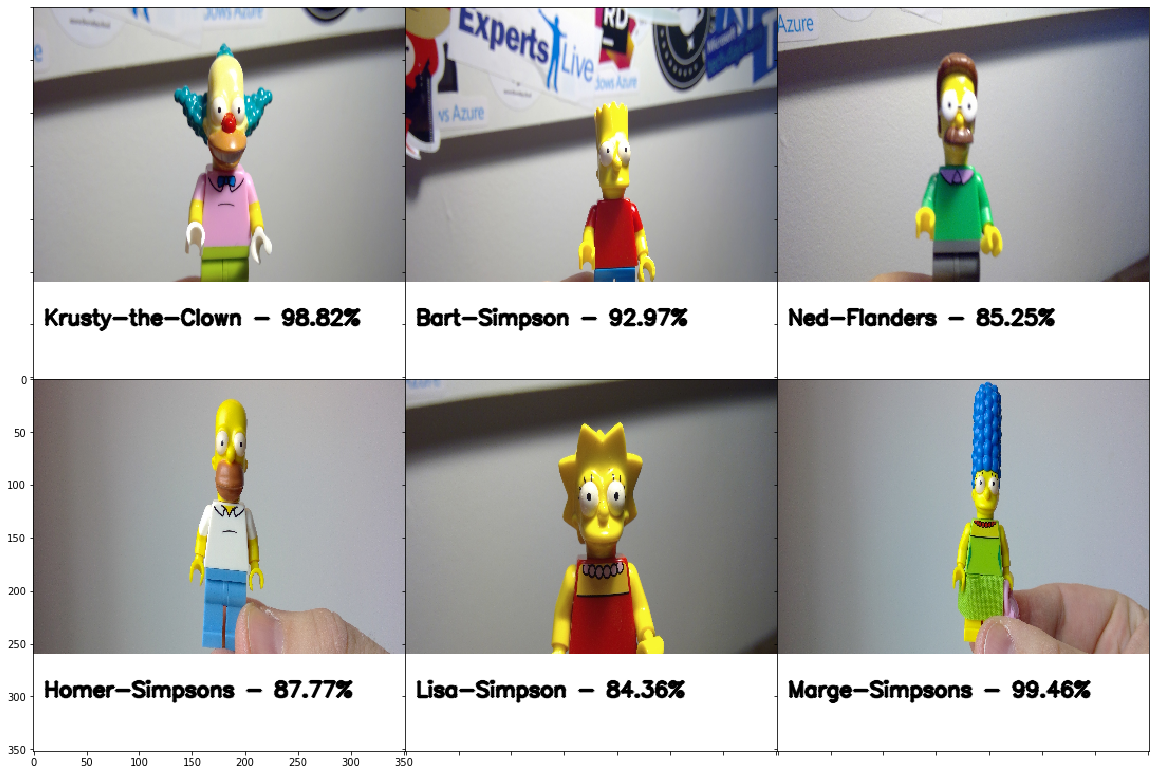

In [177]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from PIL import Image as ImagePil
import requests
from io import BytesIO
import cv2
import urllib
import cv2
import numpy as np
import json

F = plt.figure(1, (20,20))
grid = AxesGrid(F, 111, nrows_ncols=(2, 3), axes_pad=0, label_mode="1")


with open('test-images-urls.txt', 'rt') as lf:
    images = [l.strip() for l in lf.readlines()]

testimages = images


def url_to_image(url):
    with urllib.request.urlopen(url) as url:
        s = url.read()
    image = np.asarray(bytearray(s), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (352, 352))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


i = 0
for img_name in testimages[0:6]:
    
    # Predict Url
    result = aks_service.run(input_data=json.dumps({ "url": img_name}))

    # Download image
    img = url_to_image(img_name)
 
    # Draw result on image
    text = "{} - {}%".format(result['label'],result['probability'])
    cv2.rectangle(img, (0,260),(352,352),(255,255,255), -1)
    cv2.putText(img, text,(10, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.65,(0,0,0),2,cv2.LINE_AA)

    # Show image in grid
    grid[i].imshow(img)
    i = i+1